In [15]:
import matplotlib.style
matplotlib.style.use('classic')
#import matplotlib
#matplotlib.use("pdf")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import click
import scipy as sp
from pypower.api import ppoption, runpf, printpf, makeYbus
from pypower.idx_gen import PG, QG, GEN_BUS
from pypower.idx_bus import PD, QD, VM, VA, BUS_I
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
import grid_cases as gridcase
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.interpolate import griddata
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import click
import time
from numba import jit
from numba import vectorize

In [18]:
#@jit
def kuramoto_2nd_order( t,x,  P, K, alfs ):
    N = int(len( P ))
    theta = x[:N]
    dot_theta = x[N:]
    dotdot_theta = np.zeros( 2*N )
    dotdot_theta[0:N] = dot_theta
    dotdot_theta[N:] = P - np.multiply( alfs, dot_theta ) + np.sum(K * np.sin( np.repeat( theta.reshape(N,1).T, N, axis=0 ) - np.repeat( theta.reshape(N,1), N, axis=1 ) ), axis=1)

    return dotdot_theta

#@jit
def synch_condition( K, w ):
    '''
    Returns an approximation to the critical coupling and to the steady state
    of the system, calculated from topological considerations.
    '''
    G = nx.from_numpy_matrix(K)
    L_dagger = np.linalg.pinv( nx.laplacian_matrix( G ).todense() )
    B = nx.incidence_matrix( G, oriented = True ).todense()
    theta_ss = np.matmul(L_dagger, w) 
    x0 = np.concatenate((theta_ss, 0*theta_ss), axis=1).T
    x0 = x0.flatten()
    x0 = x0.tolist()
    x0 = x0[0]
    k_crit = np.linalg.norm( np.matmul( B.T, theta_ss.T ), np.inf )

    return k_crit, x0

@jit
def coupling_sweep(t_fin, points_ode, x0, k_ini, k_end, k_step, stead_time, K, P, Alf, to_plot, wrap_pi):
    start_time = time.time()
    t = np.linspace(0, t_fin, points_ode)
    N = len(P)
    stead_results = list()

    #stead_lim = int(np.floor(stead_time*(points_ode/t_fin)))

    x0_prime = x0


    for kvar in np.arange( k_ini, k_end, k_step ): 

        if (kvar <= 1.0):
            x0 = x0_prime

        print( 'Progress: ', 100*(kvar - k_ini)/(k_end - k_ini), ' %' )

        K_new = kvar*K
        #states = odeint( kuramoto_2nd_order, x0, t, args=(P, K_new, Alf) )



        #solver = ode(kuramoto_2nd_order)
        #solver.set_integrator('lsoda', method= 'bdf', atol=1e-3, rtol=1e-3)
        #solver.set_f_params(P, K_new, Alf)
        #solver.set_initial_value(x0, 0)

        
        #i = 0
        #states = []
        #t = []
        #while solver.successful() and solver.t < t_fin:
        #    solver.integrate(1e-4, step=True)
        #    states.append( solver.y )
        #    t.append(solver.t)
        #    i += 1

        #t = np.array(t)
        #states = np.array(states)

        
        solver = ode( kuramoto_2nd_order )
        solver.set_integrator('vode', method = 'bdf', order = 5, nsteps=3000)
        solver.set_f_params(P, K_new, Alf)
        solver.set_initial_value(x0, 0)
        
        
        i = 0
        states = []
        t = []
        while solver.successful() and solver.t < t_fin:
            solver.integrate(1e-1, step=True)
            states.append( solver.y )
            t.append(solver.t)
            i += 1

        t = np.array(t)
        states = np.array(states)
        

        print(states)
        
        if (wrap_pi):
            phases = ( states[:,0:N] + np.pi) % (2 * np.pi ) - np.pi
        else:
            phases = states[:,0:N]

        phase_vels = states[:,N:]

        x0 = states[-1,:]


        re_r = np.mean( np.cos( phases ), axis = 1 )
        im_r = np.mean( np.sin( phases ), axis = 1 )
        mag_r = np.sqrt( np.square(re_r) + np.square(im_r) )
        avg_vel = np.sqrt( np.mean( np.square(phase_vels) , axis = 1 ) )


        stead_re_r = np.mean( re_r[ t > stead_time ] )
        stead_mag_r = np.mean( mag_r[ t > stead_time ] )
        stead_avg_vel = np.mean( avg_vel[ t > stead_time ] )

        stead_results.append( np.array([ kvar, stead_mag_r, stead_re_r, stead_avg_vel]) )


        end_time = time.time()

        if (to_plot):

            plt.figure()
            plt.plot(t, re_r, c = 'dodgerblue', label = r"$I\!Re [r_{(t)}]$")
            plt.plot(t, im_r, c = 'mediumvioletred', label = r"$I\!Im [r_{(t)}]$")
            plt.plot(t, mag_r, c = 'darkorange', label = r"$|r_{(t)}|$")
            plt.xlabel(r'$t ~~~ \rm{[s]}$')
            plt.legend()
            plt.grid()
            #plt.xlim([0,10])
            plt.ylim([-1.1,1.1])
            plt.show()


            phases = phases[:, :50]
            phase_vels = phase_vels[:, :50]


            plt.figure()
            plt.plot(t, phases)
            plt.ylabel(r'$\theta$')
            plt.xlabel(r'$t ~~~ \rm{[s]}$')
            plt.grid()
            #plt.xlim([0,10])
            #plt.ylim([-20,20])
            plt.show()

            plt.figure()
            plt.plot(t, phase_vels)
            plt.ylabel(r'$\dot \theta$')
            plt.xlabel(r'$t ~~~ \rm{[s]}$')
            plt.grid()
            #plt.xlim([0,10])
            #plt.ylim([-20,20])
            plt.show()





    stead_results = np.array( stead_results )
    np.savetxt('Results/jupytest_mean_col_sweep_1.txt', stead_results)


    plt.figure()
    plt.plot( stead_results[:,0], stead_results[:,1], linewidth = 2, marker = 's', color = 'indigo' )
    plt.xlabel(r'$t ~~~ \rm{[s]}$')
    plt.ylabel(r"$|r_{(t)}|$")
    plt.grid()
    plt.savefig('Images_2/jupytest_col_magr_.pdf')
    plt.show()
    plt.figure()
    plt.plot( stead_results[:,0], stead_results[:,2], linewidth = 2, marker = 's', color = 'gold' )
    plt.xlabel(r'$t ~~~ \rm{[s]}$')
    plt.ylabel(r"$I\!Re [r_{(t)}]$")
    plt.grid()
    plt.savefig('Images_2/jupytest_col_rer_.pdf')
    plt.show()
    plt.figure()
    plt.plot( stead_results[:,0], stead_results[:,3], linewidth = 2, marker = 's', color = 'teal' )
    plt.xlabel(r'$t ~~~ \rm{[s]}$')
    plt.ylabel(r'$v_{\infty}$')
    plt.grid()
    plt.savefig('Images_2/jupytest_col_vinf_.pdf')
    plt.show()


    print( 'Execution time:', end_time - start_time )

    return stead_results

In [19]:
%matplotlib notebook

1.3383040936100885 1.1208214987624638
Progress:  0.0  %
[[ 9.11936994e-01  1.65906437e+00  1.44364546e+00 ... -8.38207088e-14
   2.63051087e-14  1.68471325e-14]
 [ 9.11936994e-01  1.65906437e+00  1.44364546e+00 ... -8.38290909e-10
   2.63077393e-10  1.68488172e-10]
 [ 9.11936994e-01  1.65906437e+00  1.44364546e+00 ... -9.22036178e-09
   2.89358826e-09  1.85320142e-09]
 ...
 [ 6.42712667e-01  1.15837858e+00  1.00508717e+00 ...  2.70453772e-08
  -5.81155496e-08 -1.93777038e-08]
 [ 6.42712668e-01  1.15837858e+00  1.00508717e+00 ...  2.76451355e-08
  -5.81347363e-08 -1.97808916e-08]
 [ 6.42712668e-01  1.15837858e+00  1.00508717e+00 ...  2.70820579e-08
  -5.78539432e-08 -1.96083721e-08]]


<IPython.core.display.Javascript object>


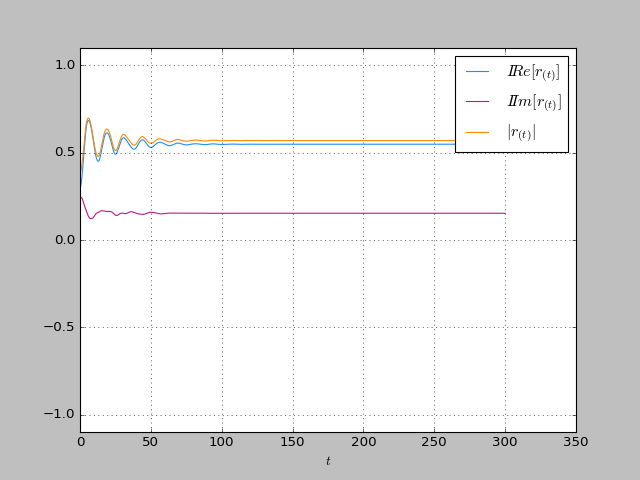

<IPython.core.display.Javascript object>


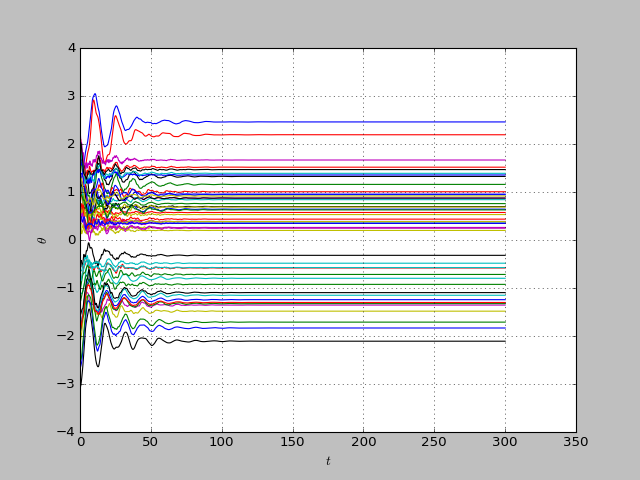

<IPython.core.display.Javascript object>


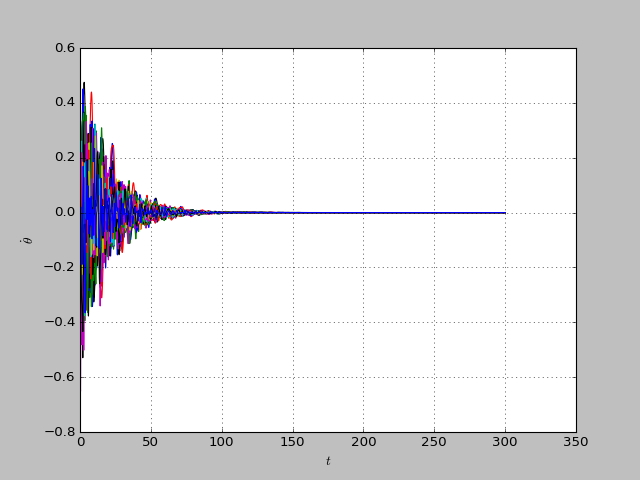

<IPython.core.display.Javascript object>


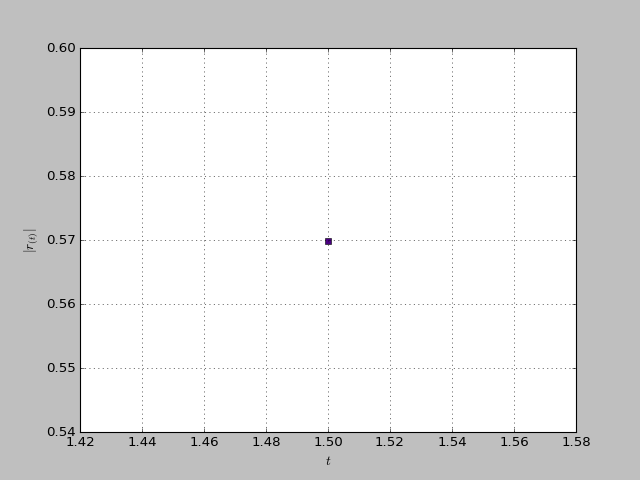

<IPython.core.display.Javascript object>


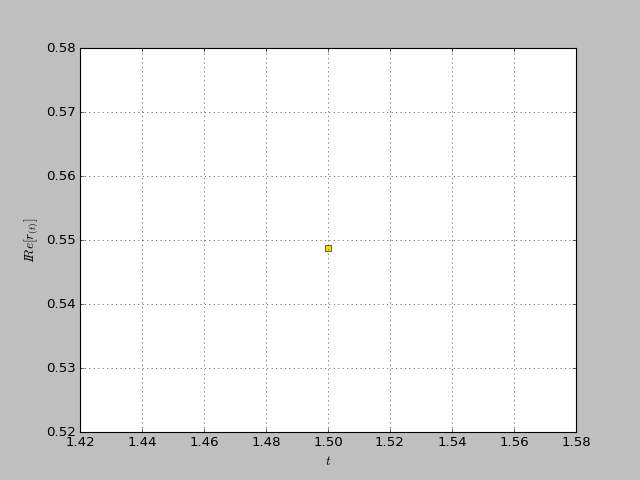

<IPython.core.display.Javascript object>


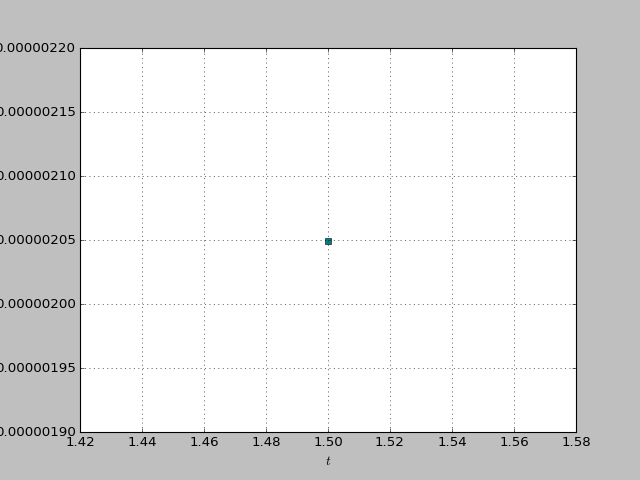

Execution time: 11.229429483413696


In [20]:
k_ini = 1.5
k_end = 1.6
k_step = 0.3
to_plot = True
wrap_pi = True

K = np.loadtxt( 'params_COL/K_Colombia_pu.txt' )
P = np.loadtxt( 'params_COL/P_Colombia_pu.txt' )
#Alf = np.loadtxt( 'params_COL/alf_Colombia_pu.txt' )
Alf = 0.1*np.ones( P.shape )
points_ode = 25000
t_fin = 300 
stead_time = 200

k_crit, x0 = synch_condition( K, P )

print( k_crit, k_ini/k_crit )


stead_results = coupling_sweep(t_fin, points_ode, x0, k_ini, k_end, k_step, stead_time, K, P, Alf, to_plot, wrap_pi)


In [8]:
stead_results

array([[1.5, nan, nan, nan]])